<a href="https://colab.research.google.com/github/inseungkang/learningalgos/blob/main/Controller_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import drivedrive.mount('/content/drive', force_remount=True)

from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/Inseung_LearningAlgos/
!pip3 install c3d

import numpy as np
import pandas as pd
import os
import fnmatch
import c3d
import matplotlib.pyplot as plt

Mounted at /content/drive
/content/drive/My Drive/Inseung_LearningAlgos


In [91]:
# This is mainly for the tied-belt trials
# Extract maker header location from each c3d files

file_dir = '/content/drive/My Drive/Inseung_LearningAlgos/c3d files/'
file_list = os.listdir('/content/drive/My Drive/Inseung_LearningAlgos/c3d files/')
file_list.sort()
header_col_list = []
for filename in file_list:
  reader = c3d.Reader(open(file_dir+filename, 'rb'))
  markerLabel = reader.point_labels
  markerName = ['RASI','LASI','RPSI','LPSI','RANL','LANL']
  header_list = []
  for _, name in enumerate(markerName):
    for idx, label in enumerate(markerLabel):
      if name == label.strip():
        header_list.append(idx)
        # /(idx)
  header_col_list.append(header_list)

# file_list = [i for i in file_list if 'Session1_R' in i]


In [146]:
# from npz files, open the file and truncate data to sync the data so we can extract 6 min of walking data (using the sync force plate)
# main trial started after the rising edge of the synce force plate
npz_dir = '/content/drive/My Drive/Inseung_LearningAlgos/npz files/'
test_file_name = 'AB4_Session1_Right14_Left14.npz'
test_file_header = header_col_list[15]

with np.load(npz_dir+test_file_name) as data:
  marker_data = data['points']
  force_data = data['analog']

force_sync = np.mean(force_data[:,14,:], axis=1)
start_idx = np.argwhere(abs(force_sync) > np.max(abs(force_sync)/2))[0,0]
end_idx = start_idx + 6*6000        #6 min of walking

foot_r = marker_data[start_idx:end_idx, test_file_header[4], 0:3]
foot_l = marker_data[start_idx:end_idx, test_file_header[5], 0:3]
com = np.mean(marker_data[start_idx:end_idx, test_file_header[0:4], 0:3], axis=1)
force_r = np.mean(force_data[start_idx:end_idx, 0:3, :], axis=2)
force_l = np.mean(force_data[start_idx:end_idx, 6:9, :], axis=2)

In [147]:
TreadmillSpeed = 1
frac_distance_from_midstance_list = 0

# Compute gait event index number (left and right). This will be in the order of left mid stance, right heel contact, right mid stance, and left heel contact
# This will be used to compute the com state during mid stance and evaluate the foot placement in the following heel contact
# here, using the com y position and foot y position, compute the mid stance (zero crossing) and heel contact (min value) from the signal: diff(com, foot)
# this is because com y location will be negative when the foot y is front of com and vice versa


# left heel contact and mid stance index based on COM Y position subtracted from left foot Y 
COM_Y_l = com[:,1] - foot_l[:,1]
zc = np.where(np.diff(np.sign(COM_Y_l)))[0]

hc_l = []
ms_l = []
for idx, value in enumerate(zc):
  if COM_Y_l[value+1] < 0:
    if idx < len(zc)-1:
      min_point = np.argmin(COM_Y_l[zc[idx]:zc[idx+1]])
      hc_idx = value+min_point
      ms_idx = zc[idx+1]
      hc_l.append(hc_idx)
      ms_l.append(ms_idx)

# right heel contact and mid stance index based on COM Y position subtracted from right foot Y 
COM_Y_r = com[:,1] - foot_r[:,1]
zc = np.where(np.diff(np.sign(COM_Y_r)))[0]

hc_r = []
ms_r = []
for idx, value in enumerate(zc):
  if COM_Y_r[value+1] < 0:
    if idx < len(zc)-1:
      min_point = np.argmin(COM_Y_r[zc[idx]:zc[idx+1]])
      hc_idx = value+min_point
      ms_idx = zc[idx+1]
      hc_r.append(hc_idx)
      ms_r.append(ms_idx)


In [148]:
# mid stance and heel contact index for left and right might match in size so truncate the first on to match the MX4 size and concatenate
# order of the gait event every loop is: ms_l, hc_r, ms_r, hc_l

gait_event_idx = np.zeros((0,4))
for idx, x in enumerate(ms_l):

  if idx+1 > len(hc_r)-1 or idx+1 > len(ms_r)-1 or idx+1 > len(hc_l)-1:
    break

  a = x

  if a < hc_r[idx]:
    b = hc_r[idx]
  else:
    b = hc_r[idx+1]

  if b < ms_r[idx]:
    c = ms_r[idx]
  else:
    c = ms_r[idx+1]

  if c < hc_l[idx]:
    d = hc_l[idx]
  else:
    d = hc_l[idx+1]
  
  gait_vec = np.array([a, b, c, d])
  gait_event_idx = np.row_stack((gait_event_idx, gait_vec))

In [149]:
# Obtain state vector for pelvis this is combination of position and velocity which was differentiated
from scipy import signal
b, a = signal.butter(2, 0.125)

COM_X_r = com[:,0] - foot_r[:,0]
COM_Y_r = com[:,1] - foot_r[:,1]
COM_Z_r = com[:,2] - foot_r[:,2]
COM_X_l = com[:,0] - foot_l[:,0]
COM_Y_l = com[:,1] - foot_l[:,1]
COM_Z_l = com[:,2] - foot_l[:,2]

COM_XX_r = np.append(np.diff(COM_X_r), np.diff(COM_X_r)[-1])
COM_YY_r = np.append(np.diff(COM_Y_r), np.diff(COM_Y_r)[-1])
COM_ZZ_r = np.append(np.diff(COM_Z_r), np.diff(COM_Z_r)[-1])
COM_XX_l = np.append(np.diff(COM_X_l), np.diff(COM_X_l)[-1])
COM_YY_l = np.append(np.diff(COM_Y_l), np.diff(COM_Y_l)[-1])
COM_ZZ_l = np.append(np.diff(COM_Z_l), np.diff(COM_Z_l)[-1])

COM_XX_r = signal.filtfilt(b, a, COM_XX_r)
COM_YY_r = signal.filtfilt(b, a, COM_YY_r)
COM_ZZ_r = signal.filtfilt(b, a, COM_ZZ_r)
COM_XX_l = signal.filtfilt(b, a, COM_XX_l)
COM_YY_l = signal.filtfilt(b, a, COM_YY_l)
COM_ZZ_l = signal.filtfilt(b, a, COM_ZZ_l)

COM_state_r = np.transpose(np.asarray((COM_X_r, COM_Z_r, COM_XX_r, COM_YY_r, COM_ZZ_r)))
COM_state_l = np.transpose(np.asarray((COM_X_l, COM_Z_l, COM_XX_l, COM_YY_l, COM_ZZ_l)))

# Obtain foot placement vector (X, Y). This is only the position vector but we need to subtract the relevant COM position to obtain foot place relative to the COM
footXY_l = np.column_stack((foot_l[:,0] - foot_r[:,0], foot_l[:,1] - foot_r[:,1]))
footXY_r = np.column_stack((foot_r[:,0] - foot_l[:,0], foot_r[:,1] - foot_l[:,1]))

# Obtain COM state and foot placement at mid stance / heel contact for left and right leg using the corresponding gait event index
COM_ms_l = COM_state_l[[int(i) for i in gait_event_idx[:,0].tolist()]]
COM_ms_r = COM_state_r[[int(i) for i in gait_event_idx[:,2].tolist()]]
footXY_hc_l = footXY_l[[int(i) for i in gait_event_idx[:,3].tolist()]]
footXY_hc_r = footXY_r[[int(i) for i in gait_event_idx[:,1].tolist()]]

# compute the nominal P_star and Q_star which is just a mean value during certain part of the gait cycle (mid stance / heel contact)
COM_ms_norm_l = np.mean(COM_ms_l, axis=0)
COM_ms_norm_r = np.mean(COM_ms_r, axis=0)
footXY_hc_norm_l = np.mean(footXY_hc_l, axis=0)
footXY_hc_norm_r = np.mean(footXY_hc_r, axis=0)

delta_P_r = COM_ms_r - COM_ms_norm_r
delta_P_l = COM_ms_l - COM_ms_norm_l
delta_Q_r = footXY_hc_l - footXY_hc_norm_l
delta_Q_l = footXY_hc_r - footXY_hc_norm_r


# plt.plot(com[:,1]-foot_r[:,1],'red')
# plt.plot(com[:,1]-foot_l[:,1],'blue')

# plt.plot(ms_r, com[ms_r,1]-foot_r[ms_r,1], 'o')
# plt.plot(hc_l, com[hc_l,1]-foot_l[hc_l,1], 'x')
# plt.plot(ms_l, com[ms_l,1]-foot_l[ms_l,1], '*')
# plt.xlim(11000, 11500)
# plt.show()

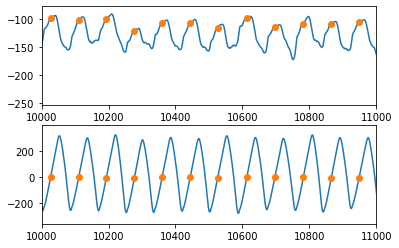

In [128]:
fig, axs = plt.subplots(2)
range = [10000, 11000]
COM_Y = com[:,1] - foot_r[:,1]

axs[0].plot(COM_X_r)
axs[0].plot(ms_r, COM_X_r[ms_r], 'o')

axs[1].plot(COM_Y)
# axs[1].plot(com[:,1]- foot_l[:,1])

axs[1].plot(ms_r, COM_Y[ms_r], 'o')

axs[0].set_xlim(range)
axs[1].set_xlim(range)
plt.show()

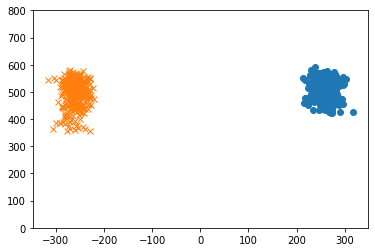

In [127]:
# footXY_hc_r_1 = footXY_hc_r

# plt.plot(footXY_hc_r_0[:,0],footXY_hc_r_0[:,1],'o')
# plt.plot(footXY_hc_r_1[:,0],footXY_hc_r_1[:,1],'o')
plt.plot(footXY_hc_r[10:,0],footXY_hc_r[10:,1],'o')
plt.plot(footXY_hc_l[10:,0],footXY_hc_l[10:,1],'x')

# plt.xlim(-200, 400)
plt.ylim(0, 800)
plt.show()

0.5489745894705071


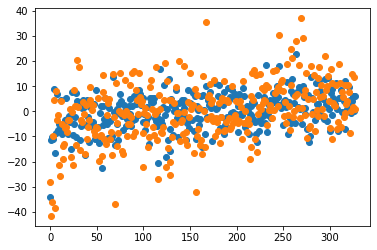

In [150]:
from sklearn.linear_model import LinearRegression

regression = LinearRegression(fit_intercept = False)
linear_model = regression.fit(delta_P_r, delta_Q_r)
print(linear_model.score(delta_P_r, delta_Q_r))
pred = linear_model.predict(delta_P_r)

plt.plot(pred[:,1],'o')
plt.plot(delta_Q_r[:,1],'o')
plt.show()

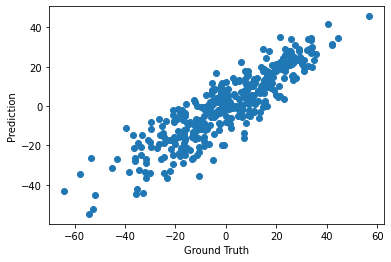

In [145]:
plt.plot(delta_Q_r[:,0],pred[:,0], 'o')
# plt.xlim(-20, 20)
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()